In [ ]:
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env LLM_API_KEY=sk-替换为自己的Qwen API Key

In [2]:
%%capture --no-stderr
!pip install -U langchain langchain-community langchain-openai langchain-cohere pypdf sentence_transformers chromadb shutil openpyxl FlagEmbedding cohere

In [3]:
import os
import pandas as pd

In [4]:
expr_version = 'retrieval_v13_contextual_embeddings'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

os.makedirs(expr_dir, exist_ok=True)

# 读取文档

In [5]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))
documents = loader.load()

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

# 文档切分

In [6]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [7]:
splitted_docs = split_docs(documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


In [8]:
import re
from langchain.schema import Document

# 去除页眉
pattern = r"^全球经济金融展望报告\n中国银行研究院 \d+ 2024年"
doc_content = '\n'.join(re.sub(pattern, '', doc.page_content) for doc in documents)

# 检索

In [9]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings

device: cuda


## 构建Contextual Embeddings

In [10]:
from langchain.chat_models import ChatOllama

In [11]:
llm = ChatOllama(
    model='qwen2:7b-instruct-32k',
    base_url='http://localhost:11434',
    top_k=1
)

/tmp/ipykernel_3007024/2314240529.py:1: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(


In [12]:
DOCUMENT_CONTEXT_PROMPT = """
<document>
{doc_content}
</document>
"""

CHUNK_CONTEXT_PROMPT = """
这是我们想要放置在整个文档中的片段。
<chunk>
{chunk_content}
</chunk>

请为了提高检索效率，给出一个简短而精确的上下文来定位这个片段在整个文件中的位置。
"""

def situate_context(doc: str, chunk: str) -> str:
    messages = [
        ("user", DOCUMENT_CONTEXT_PROMPT.format(doc_content=doc)),
        ("user", CHUNK_CONTEXT_PROMPT.format(chunk_content=chunk)),
    ]
    return llm.invoke(messages).content

In [13]:
situate_context(doc_content, chunk=splitted_docs[0].page_content)

'这个片段位于文档的开头部分。它概述了2023年全球经济金融的基本情况和2024年的展望，并提到了报告的主要作者、联系信息以及数据来源（IMF和中国银行研究院）。此外，该片段还简要介绍了全球主要经济体GDP增速的变化趋势。因此，这个片段可以作为文档的引言部分，用于概述研究的重点内容和背景信息。\n\n上下文定位：\n- **位置**：文档开头\n- **作用**：提供2023年全球经济金融概览、报告作者与联系方式、数据来源以及主要经济体GDP增速变化趋势的简要介绍。\n- **重要性**：为读者提供了对报告核心内容的快速了解，帮助他们理解研究的主要发现和背景。\n\n通过这个片段，我们可以定位到文档的引言部分，它通常用于概述研究的目的、方法、关键发现等，并提供必要的上下文信息。'

In [14]:
from tqdm.auto import tqdm

contextualized_chunks = []
for chunk in tqdm(splitted_docs):
    contextualized_text = situate_context(doc_content, chunk)
    contextualized_chunks.append(
        Document(
            page_content=chunk.page_content + '\n\n' + contextualized_text,
            metadata=chunk.metadata
        )
    )

  0%|          | 0/52 [00:00<?, ?it/s]

In [15]:
contextualized_chunks[0]

Document(metadata={'source': 'data/2024全球经济金融展望报告.pdf', 'page': 0, 'uuid': 'e73a0c9d-d42b-4350-a4c3-b38bf67c68a5'}, page_content='研究院\n全球经济金融展望报告\n要点2024年年报（总第57期） 报告日期：2023年12月12日\n●2023年全球经济增长动力持续回落，各国复苏分化，\n发达经济体增速明显放缓，新兴经济体整体表现稳定。\n全球贸易增长乏力，各国生产景气度逐渐回落，内需\n对经济的拉动作用减弱。欧美央行货币政策紧缩态势\n放缓，美元指数高位震荡后走弱，全球股市表现总体\n好于预期，但区域分化明显。高利率环境抑制债券融\n资需求，债券违约风险持续上升。\n●展望2024年，预计全球经济复苏将依旧疲软，主要\n经济体增长态势和货币政策走势将进一步分化。欧美\n央行大概率结束本轮紧缩货币周期，美元指数将逐步\n走弱，流向新兴经济体的跨境资本将增加。国际原油\n市场短缺格局或延续，新能源发展成为重点。\n●海湾六国经济发展与投资前景、高利率和高债务对\n美国房地产市场脆弱性的影响等热点问题值得关注。中国银行研究院\n全球经济金融研究课题组\n组长：陈卫东\n副组长：钟红\n廖淑萍\n成员：边卫红\n熊启跃\n王有鑫\n曹鸿宇\n李颖婷\n王宁远\n初晓\n章凯莉\n黄小军（纽约）\n陆晓明（纽约）\n黄承煜（纽约）\n宋达志（伦敦）\n李振龙（伦敦）\n张传捷（伦敦）\n刘冰彦（法兰克福）\n温颍坤（法兰克福）\n张明捷（法兰克福）\n王哲（东京）\n李彧（香港）\n黎永康（香港）\n联系人：王有鑫\n电话：010-66594127\n邮件：wangyouxin_hq@bank-of-china.com主要经济体GDP增速变化趋势（%）\n资料来源：IMF，中国银行研究院\n\n这个片段位于文档的开头部分，作为“全球经济金融展望报告”的摘要或简介。它概述了2023年全球经济增长、贸易和货币政策的主要趋势，并预测了2024年的经济前景。该片段还提到了几个关键的研究课题，包括海湾六国的经济发展与投资前景、美国房地产市场的脆弱性等热点问题。\n\n这个部分提供了报告的主题框架和主要关注点，帮助读者快速了解报告的核心内容。它通常位于文档的

In [16]:
import shutil

from tqdm.auto import tqdm
from langchain_community.vectorstores import Chroma

model_path = 'BAAI/bge-large-zh-v1.5'
embeddings = get_embeddings(model_path)

persist_directory = os.path.join(expr_dir, 'chroma', 'bge')
shutil.rmtree(persist_directory, ignore_errors=True)
vector_db = Chroma.from_documents(
    contextualized_chunks,
    embedding=embeddings,
    persist_directory=persist_directory
)

## 计算检索准确率

In [17]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

In [18]:
def get_hit_stat_df(top_k_arr=list(range(1, 9))):
    hit_stat_data = []

    for k in tqdm(top_k_arr):
        for idx, row in test_df.iterrows():
            question = row['question']
            true_uuid = row['uuid']
            # chunks = retrieve_fn(question, k=k)
            chunks = vector_db.similarity_search(question, k=k)
            retrieved_uuids = [doc.metadata['uuid'] for doc in chunks]

            hit_stat_data.append({
                'question': question,
                'top_k': k,
                'hit': int(true_uuid in retrieved_uuids),
                'retrieved_chunks': len(chunks)
            })
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

In [19]:
hit_stat_df = get_hit_stat_df()

  0%|          | 0/8 [00:00<?, ?it/s]

In [20]:
hit_stat_df.groupby(['top_k'])['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,top_k,hit_rate
0,1,0.419355
1,2,0.580645
2,3,0.688172
3,4,0.752688
4,5,0.817204
5,6,0.827957
6,7,0.838710
7,8,0.838710


<Axes: xlabel='top_k', ylabel='hit'>

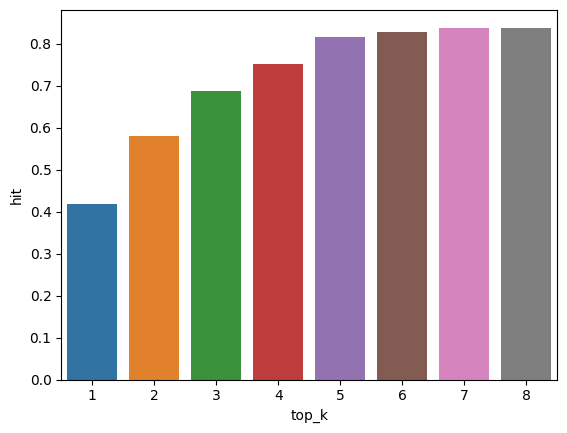

In [21]:
import seaborn as sns

sns.barplot(x='top_k', y='hit', data=hit_stat_df, errorbar=None)

# 生成答案

In [22]:
def rag(llm, query, n_chunks=4):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()
    chunks = vector_db.similarity_search(query, k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)
    retry_count = 3

    resp = ''
    while retry_count > 0:
        try:
            resp = llm.invoke(prompt)
            break
        except Exception as e:
            retry_count -= 1
            sleeping_seconds = 2 ** (4 - retry_count)
            print(f"query={query}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
            
            time.sleep(sleeping_seconds)
    
    return resp, chunks

## 预测

In [23]:
from langchain.llms import Ollama

ollama_llm = Ollama(
    model='qwen2:7b-instruct-32k',
    # model='qwen2:7b-instruct',
    base_url='http://localhost:11434',
    top_k=1
)

/tmp/ipykernel_3007024/432419542.py:3: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  ollama_llm = Ollama(


In [24]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(llm, prediction_df, n_chunks):
    prediction_df = prediction_df.copy()
    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(llm, question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }
        
    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

In [25]:
save_path = os.path.join(expr_dir, 'predictions.pkl')

if os.path.exists(save_path):
    pred_dfs = pickle.load(open(save_path, 'rb'))
else:
    pred_dfs = {}

In [26]:
pred_df = predict(ollama_llm, prediction_df, n_chunks=3)

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
save_path = os.path.join(expr_dir, 'pred_df.pkl')

if not os.path.exists(save_path):
    print(f'saving to {save_path}')
    pickle.dump(pred_df, open(save_path, 'wb'))

# 评估

In [28]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in prediction_df.iterrows():
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        
        retry_count = 3
        result = ''
        
        while retry_count > 0:
            try:
                result = judge_llm.invoke(prompt).content
                break
            except Exception as e:
                retry_count -= 1
                sleeping_seconds = 2 ** (4 - retry_count)
                print(f"query={question}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
                
                time.sleep(sleeping_seconds)
        
        results.append(result)

        time.sleep(1)
    return results

In [29]:
pred_df['raw_score'] = evaluate(pred_df)

In [30]:
pred_df['raw_score'].unique()

array(['是', '否'], dtype=object)

In [31]:
pred_df['score'] = (pred_df['raw_score'] == '是').astype(int)

In [32]:
pred_df['score'].mean()

0.68

In [33]:
save_path = os.path.join(expr_dir, 'eval_df.pkl')

if not os.path.exists(save_path):
    print(f'saving to {save_path}')
    pickle.dump(pred_df, open(save_path, 'wb'))